2025-11-16 22:16:27.892100: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-16 22:16:28.717011: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Resolved model path: /home/rameyjm7/workspace/ML-wireless-signal-classification/models/lstm_rnn_2024.keras


2025-11-16 22:16:29.491646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14784 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2025-11-16 22:16:29.770936: W external/local_xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:510] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-12.3
  /usr/local/cuda
  /usr/local/lib/python3.10/dist-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /usr/local/lib/python3.10/dist-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xl

Model loaded successfully.


2025-11-16 22:16:36.281331: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900
2025-11-16 22:16:36.318885: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:190] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


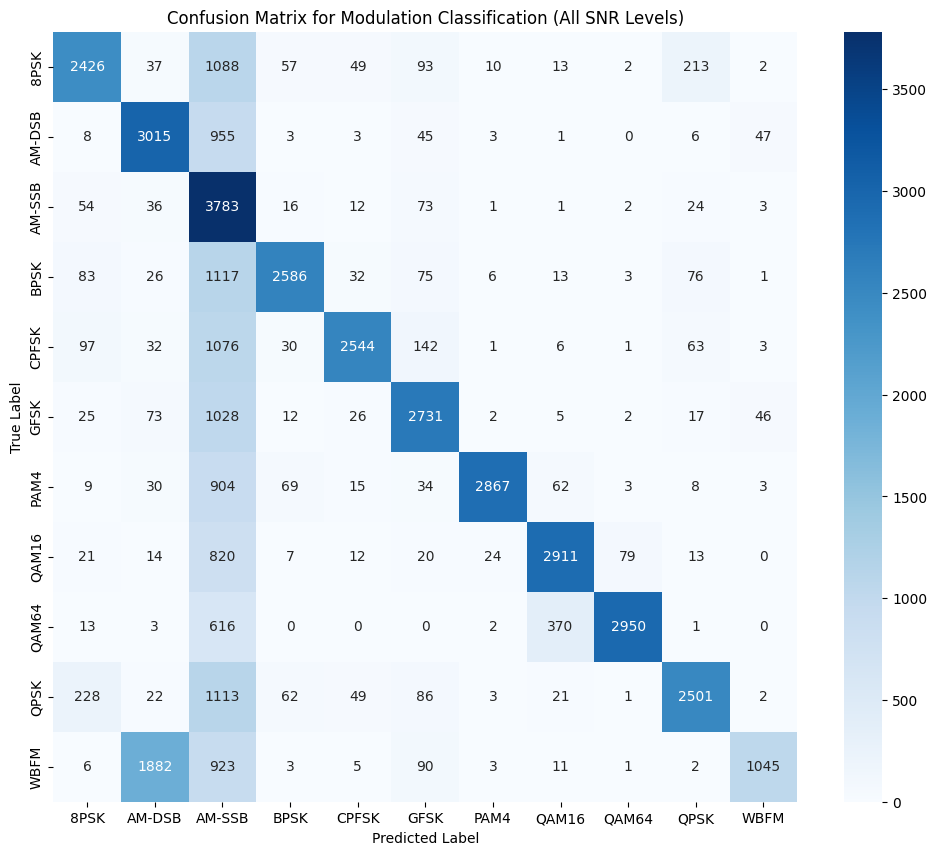

Classification Report for Modulation Types:
              precision    recall  f1-score   support

        8PSK       0.82      0.61      0.70      3990
      AM-DSB       0.58      0.74      0.65      4086
      AM-SSB       0.28      0.94      0.43      4005
        BPSK       0.91      0.64      0.75      4018
       CPFSK       0.93      0.64      0.75      3995
        GFSK       0.81      0.69      0.74      3967
        PAM4       0.98      0.72      0.83      4004
       QAM16       0.85      0.74      0.79      3921
       QAM64       0.97      0.75      0.84      3955
        QPSK       0.86      0.61      0.71      4088
        WBFM       0.91      0.26      0.41      3971

    accuracy                           0.67     44000
   macro avg       0.81      0.67      0.69     44000
weighted avg       0.81      0.67      0.69     44000



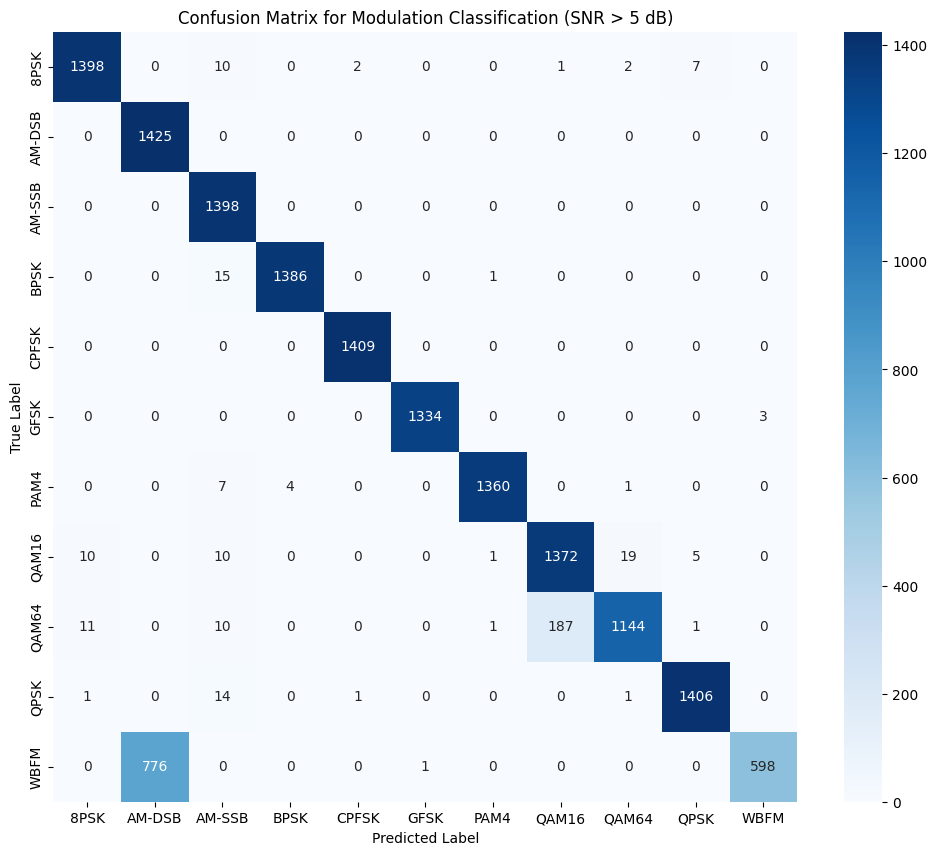

Classification Report for Modulation Types (SNR > 5 dB):
              precision    recall  f1-score   support

        8PSK       0.98      0.98      0.98      1420
      AM-DSB       0.65      1.00      0.79      1425
      AM-SSB       0.95      1.00      0.98      1398
        BPSK       1.00      0.99      0.99      1402
       CPFSK       1.00      1.00      1.00      1409
        GFSK       1.00      1.00      1.00      1337
        PAM4       1.00      0.99      0.99      1372
       QAM16       0.88      0.97      0.92      1417
       QAM64       0.98      0.84      0.91      1354
        QPSK       0.99      0.99      0.99      1423
        WBFM       1.00      0.43      0.61      1375

    accuracy                           0.93     15332
   macro avg       0.95      0.93      0.92     15332
weighted avg       0.95      0.93      0.92     15332



In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
import tensorflow as tf
import os

# Always resolve path relative to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
model_path = os.path.join(project_root, "models", "lstm_rnn_2024.keras")

print("Resolved model path:", model_path)
assert os.path.exists(model_path), f"Model file not found: {model_path}"

model = load_model(model_path)
print("Model loaded successfully.")


# Load the data
with open("../data/RML2016/RML2016.10a_dict.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")

# Prepare the data using your specific format
def prepare_data(data):
    X, y = [], []

    for (mod_type, snr), signals in data.items():
        for signal in signals:
            iq_signal = np.vstack([signal[0], signal[1]]).T
            snr_signal = np.full((128, 1), snr)
            combined_signal = np.hstack([iq_signal, snr_signal])
            X.append(combined_signal)
            y.append(mod_type)

    X = np.array(X)
    y = np.array(y)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42
    )
    X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2])
    X_test = X_test.reshape(-1, X_test.shape[1], X_test.shape[2])

    return X_train, X_test, y_train, y_test, label_encoder

# Prepare the data
X_train, X_test, y_train, y_test, label_encoder = prepare_data(data)

# Make predictions on the test set
y_pred = np.argmax(model.predict(X_test, verbose=False), axis=1)

# Plot the confusion matrix for all SNR levels
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Modulation Classification (All SNR Levels)")
plt.show()

# Print the classification report
print("Classification Report for Modulation Types:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Plot feature importance (if using a tree-based model)
# Plot confusion matrix for SNR > 5 dB subset
snr_above_5_indices = np.where(X_test[:, 0, 2] > 5)  # Assuming SNR values are in the third column
X_test_snr_above_5 = X_test[snr_above_5_indices]
y_test_snr_above_5 = y_test[snr_above_5_indices]

# Make predictions on the SNR > 5 dB subset
y_pred_snr_above_5 = np.argmax(model.predict(X_test_snr_above_5, verbose=False), axis=1)

# Plot confusion matrix for SNR > 5 dB
conf_matrix_snr_above_5 = confusion_matrix(y_test_snr_above_5, y_pred_snr_above_5)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_snr_above_5, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Modulation Classification (SNR > 5 dB)")
plt.show()

# Print the classification report for SNR > 5 dB
print("Classification Report for Modulation Types (SNR > 5 dB):")
print(classification_report(y_test_snr_above_5, y_pred_snr_above_5, target_names=label_encoder.classes_))


SNR: -20.0 dB, Accuracy: 8.06%
SNR: -18.0 dB, Accuracy: 8.30%
SNR: -16.0 dB, Accuracy: 10.43%
SNR: -14.0 dB, Accuracy: 15.84%
SNR: -12.0 dB, Accuracy: 25.44%
SNR: -10.0 dB, Accuracy: 39.64%
SNR: -8.0 dB, Accuracy: 53.18%
SNR: -6.0 dB, Accuracy: 74.10%
SNR: -4.0 dB, Accuracy: 83.48%
SNR: -2.0 dB, Accuracy: 89.89%
SNR: 0.0 dB, Accuracy: 92.21%
SNR: 2.0 dB, Accuracy: 93.44%
SNR: 4.0 dB, Accuracy: 93.48%
SNR: 6.0 dB, Accuracy: 92.70%
SNR: 8.0 dB, Accuracy: 93.86%
SNR: 10.0 dB, Accuracy: 93.25%
SNR: 12.0 dB, Accuracy: 93.29%
SNR: 14.0 dB, Accuracy: 92.69%
SNR: 16.0 dB, Accuracy: 91.59%
SNR: 18.0 dB, Accuracy: 92.29%


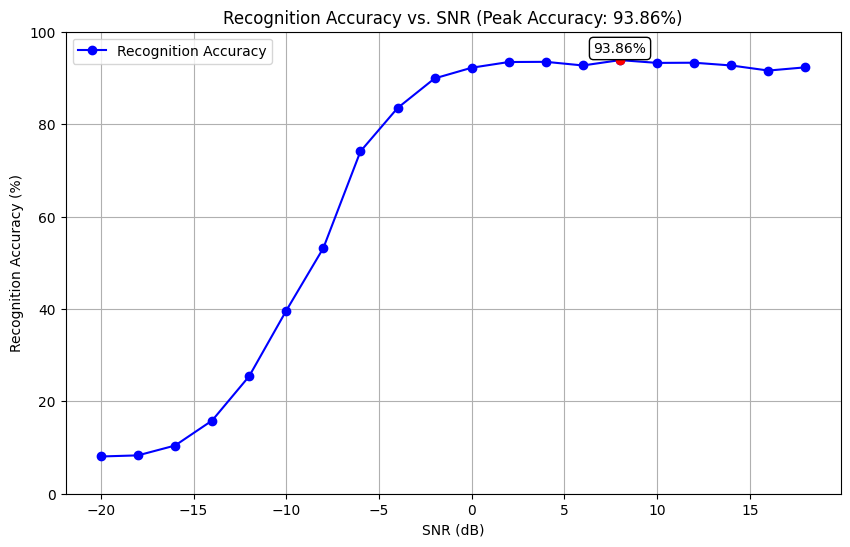

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Load data and prepare using your prepare_data function
X_train, X_test, y_train, y_test, label_encoder = prepare_data(data)

# Evaluate accuracy for each SNR level
unique_snrs = sorted(set(X_test[:, 0, -1]))  # SNR values are in the last column of each sample
accuracy_per_snr = []

for snr in unique_snrs:
    # Select samples with the current SNR
    snr_indices = np.where(X_test[:, 0, -1] == snr)
    X_snr = X_test[snr_indices]
    y_snr = y_test[snr_indices]

    # Predict and calculate accuracy
    y_pred = np.argmax(model.predict(X_snr,verbose=0), axis=1)
    accuracy = accuracy_score(y_snr, y_pred)
    accuracy_per_snr.append(accuracy * 100)  # Convert to percentage

    print(f"SNR: {snr} dB, Accuracy: {accuracy * 100:.2f}%")

# Find the peak accuracy and its corresponding SNR
peak_accuracy = max(accuracy_per_snr)
peak_snr = unique_snrs[accuracy_per_snr.index(peak_accuracy)]

# Plot Recognition Accuracy vs. SNR
plt.figure(figsize=(10, 6))
plt.plot(unique_snrs, accuracy_per_snr, 'b-o', label='Recognition Accuracy')
plt.xlabel("SNR (dB)")
plt.ylabel("Recognition Accuracy (%)")
plt.title(f"Recognition Accuracy vs. SNR (Peak Accuracy: {peak_accuracy:.2f}%)")

# Mark the peak accuracy point
plt.plot(peak_snr, peak_accuracy, 'ro')  # Red dot at the peak
plt.text(peak_snr, peak_accuracy + 1, f"{peak_accuracy:.2f}%", 
         ha='center', va='bottom', fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.show()


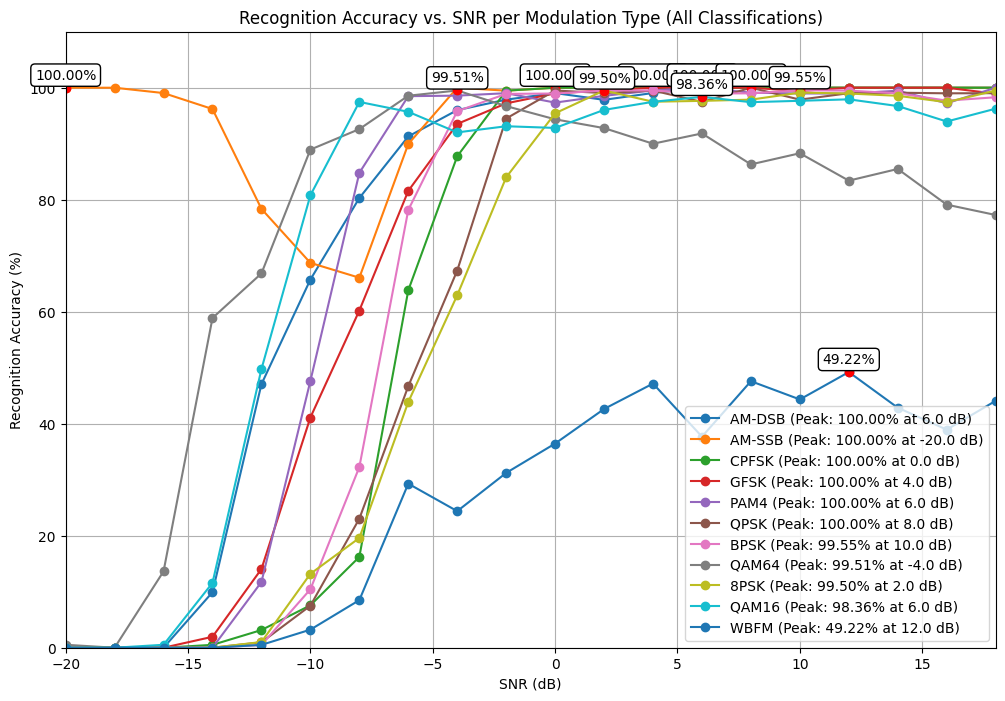

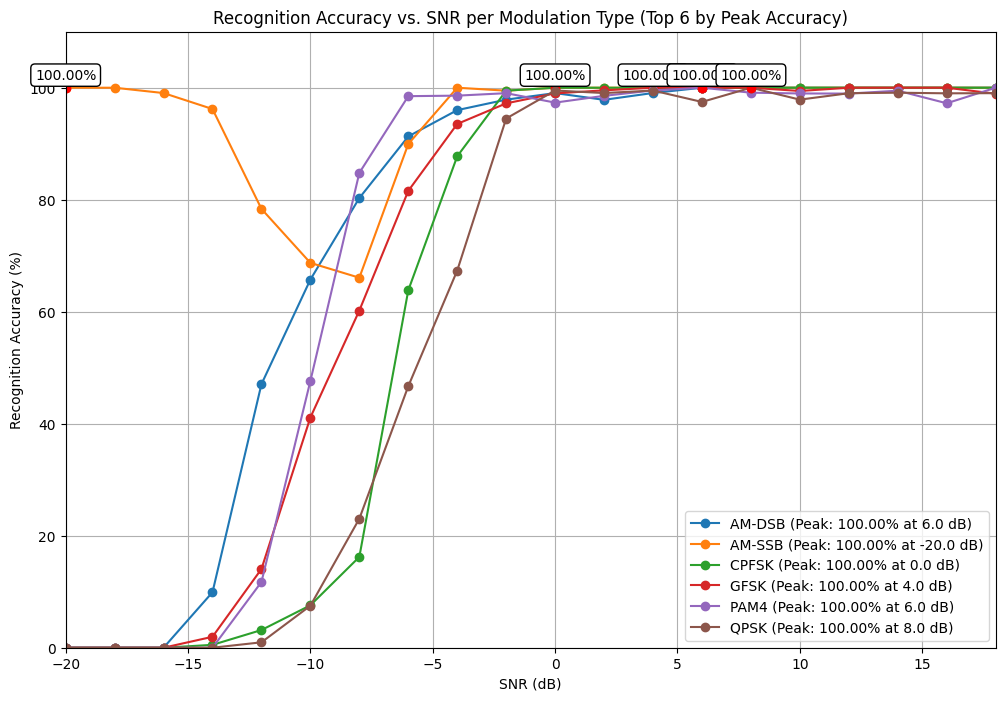

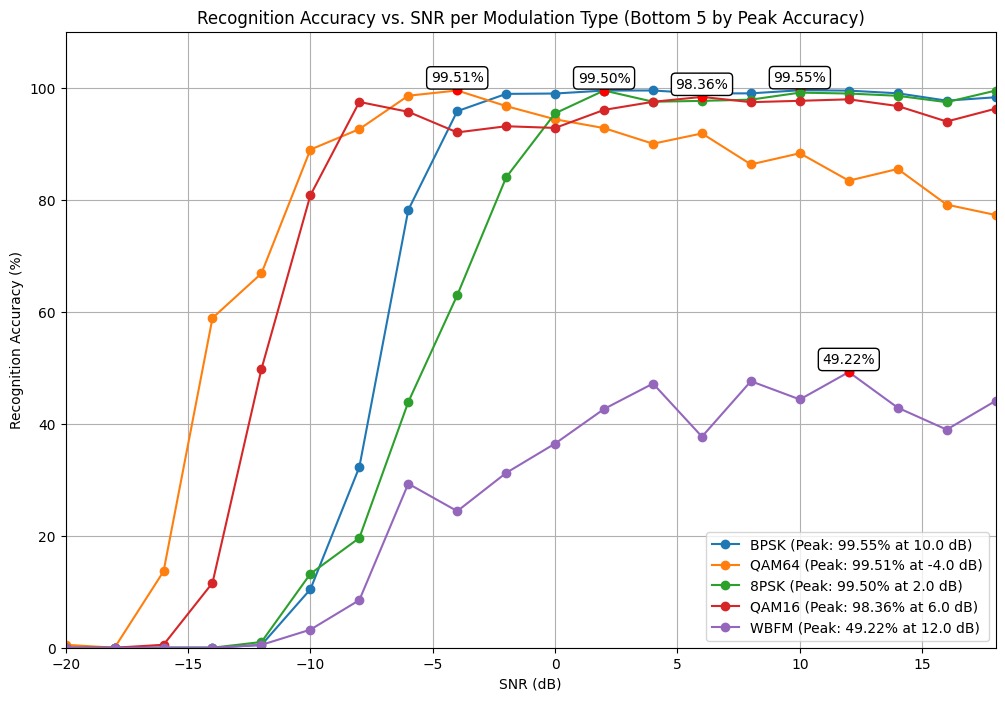

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import tensorflow as tf
# Set TensorFlow logging level to suppress most of the output
tf.get_logger().setLevel('ERROR')
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def rnn_lstm_plot_accuracy_v_snr_per_classification(model, X_test, y_test, label_encoder):
    # Get unique modulation types using label encoder classes
    unique_modulations = label_encoder.classes_  # This will be the actual class names
    unique_snrs = sorted(set(X_test[:, 0, -1]))  # Get unique SNR levels (assuming SNR is in the last column of each sample)

    # Initialize a list to store modulation, accuracy per SNR, and peak accuracy for sorting
    modulation_traces = []

    # Calculate accuracy for each modulation type and SNR level
    for mod_index, mod in enumerate(unique_modulations):
        accuracies = []
        for snr in unique_snrs:
            # Select samples with the current modulation type and SNR
            mod_snr_indices = np.where((y_test == mod_index) & (X_test[:, 0, -1] == snr))
            X_mod_snr = X_test[mod_snr_indices]
            y_mod_snr = y_test[mod_snr_indices]

            # Predict and calculate accuracy
            if len(y_mod_snr) > 0:  # Check if there are samples for this SNR and modulation type
                y_pred = np.argmax(model.predict(X_mod_snr, verbose=False), axis=1)
                accuracy = accuracy_score(y_mod_snr, y_pred) * 100  # Convert to percentage
            else:
                accuracy = np.nan  # No data for this SNR-modulation combination

            accuracies.append(accuracy)

        # Calculate peak accuracy for this modulation type
        valid_accuracies = [acc for acc in accuracies if not np.isnan(acc)]
        peak_accuracy = max(valid_accuracies) if valid_accuracies else 0
        peak_snr = unique_snrs[accuracies.index(peak_accuracy)] if peak_accuracy > 0 else None

        # Store the modulation trace data along with peak accuracy for sorting
        modulation_traces.append((mod, accuracies, peak_accuracy, peak_snr))

    # Sort the modulation types by peak accuracy in descending order
    modulation_traces = sorted(modulation_traces, key=lambda x: x[2], reverse=True)

    # Plot Recognition Accuracy vs. SNR for each modulation type (All)
    plt.figure(figsize=(12, 8))
    for mod, accuracies, peak_accuracy, peak_snr in modulation_traces:
        label = f'{mod} (Peak: {peak_accuracy:.2f}% at {peak_snr} dB)' if peak_accuracy > 0 else mod
        plt.plot(unique_snrs, accuracies, '-o', label=label)

        # Mark the peak accuracy point if it exists
        if peak_accuracy > 0 and peak_snr is not None:
            plt.plot(peak_snr, peak_accuracy, 'ro')  # Red dot at the peak
            plt.text(peak_snr, peak_accuracy + 1, f"{peak_accuracy:.2f}%", 
                    ha='center', va='bottom', fontsize=10, 
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    plt.xlabel("SNR (dB)")
    plt.ylabel("Recognition Accuracy (%)")
    plt.title("Recognition Accuracy vs. SNR per Modulation Type (All Classifications)")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.ylim(0, 110)
    plt.xlim(min(unique_snrs), max(unique_snrs))
    plt.show()

    # Plot Recognition Accuracy vs. SNR for each modulation type (Top 6 by Peak Accuracy)
    plt.figure(figsize=(12, 8))
    for mod, accuracies, peak_accuracy, peak_snr in modulation_traces[:6]:
        label = f'{mod} (Peak: {peak_accuracy:.2f}% at {peak_snr} dB)' if peak_accuracy > 0 else mod
        plt.plot(unique_snrs, accuracies, '-o', label=label)

        # Mark the peak accuracy point if it exists
        if peak_accuracy > 0 and peak_snr is not None:
            plt.plot(peak_snr, peak_accuracy, 'ro')  # Red dot at the peak
            plt.text(peak_snr, peak_accuracy + 1, f"{peak_accuracy:.2f}%", 
                    ha='center', va='bottom', fontsize=10, 
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    plt.xlabel("SNR (dB)")
    plt.ylabel("Recognition Accuracy (%)")
    plt.title("Recognition Accuracy vs. SNR per Modulation Type (Top 6 by Peak Accuracy)")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.ylim(0, 110)
    plt.xlim(min(unique_snrs), max(unique_snrs))
    plt.show()

    # Plot Recognition Accuracy vs. SNR for each modulation type (Bottom 5 by Peak Accuracy)
    plt.figure(figsize=(12, 8))
    for mod, accuracies, peak_accuracy, peak_snr in modulation_traces[-5:]:
        label = f'{mod} (Peak: {peak_accuracy:.2f}% at {peak_snr} dB)' if peak_accuracy > 0 else mod
        plt.plot(unique_snrs, accuracies, '-o', label=label)

        # Mark the peak accuracy point if it exists
        if peak_accuracy > 0 and peak_snr is not None:
            plt.plot(peak_snr, peak_accuracy, 'ro')  # Red dot at the peak
            plt.text(peak_snr, peak_accuracy + 1, f"{peak_accuracy:.2f}%", 
                    ha='center', va='bottom', fontsize=10, 
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    plt.xlabel("SNR (dB)")
    plt.ylabel("Recognition Accuracy (%)")
    plt.title("Recognition Accuracy vs. SNR per Modulation Type (Bottom 5 by Peak Accuracy)")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.ylim(0, 110)
    plt.xlim(min(unique_snrs), max(unique_snrs))
    plt.show()

    
rnn_lstm_plot_accuracy_v_snr_per_classification(model, X_test, y_test, label_encoder)
